# Hyperparameters

| hyperparameter|FP|AIT|FLVL|FLVU|HCOM|
|--------------:|-:|--:|---:|---:|---:|
| hidden_size | 64 | 128 | 256 | 512 | 256 |
| dropout | 0.279 | 0.298 | 0.238 | 0.268 | 0.276 |
| num_layers | 3 | 3 | 4 | 6 | 7 |
| num_timesteps | 5 | 8 | 5 | 6 | 4 |
| lr_init | 0.01 | 0.001 | 0.0001 | 0.0001 | 0.0001 |
| gamma | 0.978 | 0.982 | 0.979 | 0.979 | 0.986 |
| weight_decay | 3.82 $\times$ 10$^{-3}$ | 2.37 $\times$ 10$^{-4}$ | 1.39 $\times$ 10$^{-2}$ | 6.36 $\times$ 10$^{-2}$ | 6.72 $\times$ 10$^{-3}$ |

In [1]:
optimized = {
    'FP' : {'hidden_size' : 64, 'dropout' : 0.279, 'num_layers' : 3, 'num_timesteps' : 5, 'lr_init' : 0.01, 'gamma' : 0.978, 'weight_decay' : 3.82E-3},
    'AIT' : {'hidden_size' : 128, 'dropout' : 0.298, 'num_layers' : 3, 'num_timesteps' : 8, 'lr_init' : 0.001, 'gamma' : 0.982, 'weight_decay' : 2.37E-4},
    'HCOM' : {'hidden_size' : 256, 'dropout' : 0.276, 'num_layers' : 7, 'num_timesteps' : 4, 'lr_init' : 0.0001, 'gamma' : 0.986, 'weight_decay' : 6.72E-3},
    'FLVL' : {'hidden_size' : 256, 'dropout' : 0.238, 'num_layers' : 4, 'num_timesteps' : 5, 'lr_init' : 0.0001, 'gamma' : 0.979, 'weight_decay' : 1.39E-2},
    'FLVU' : {'hidden_size' : 512, 'dropout' : 0.268, 'num_layers' : 6, 'num_timesteps' : 6, 'lr_init' : 0.0001, 'gamma' : 0.979, 'weight_decay' : 6.36E-3},
    
    'MOUSE_INTRAPERITONEAL_LDLo' : {'hidden_size' : 256, 'dropout' : 0.254, 'num_layers' : 8, 'num_timesteps' : 9, 'lr_init' : 0.001, 'gamma' : 0.978, 'weight_decay' : 1.00E-2},
    'IGC50' : {'hidden_size' : 512, 'dropout' : 0.265, 'num_layers' : 7, 'num_timesteps' : 9, 'lr_init' : 0.001, 'gamma' : 0.987, 'weight_decay' : 2.73E-2},
    'LC50' : {'hidden_size' : 64, 'dropout' : 0.326, 'num_layers' : 4, 'num_timesteps' : 2, 'lr_init' : 0.01, 'gamma' : 0.982, 'weight_decay' : 7.41E-4},
}

# Parameter Setting

In [2]:
parameters = dict(
    subfrag_size = 12,
    edge_size = 3,
    out_size = 1,
    seed = 42,
    batch_size = 256,
    max_epoch = 200,
    verbose = True,
    save = False,
    
    target = 'FLVU',
)
parameters = parameters | optimized[parameters['target']]

DATAPATH = "/SSD2/bgkang/Chemomile"

MODELPATH = dict(
    FP = "../Model/FP-2024-07-17-02-08-03", # FP
    AIT = "../Model/AIT-2024-07-17-02-21-21", # AIT
    FLVL = "../Model/FLVL-2024-07-17-02-25-23", # FLVL
    FLVU = "../Model/FLVU-2024-07-17-02-29-19", # FLVU
    HCOM = "../Model/HCOM-2024-07-17-04-48-42", # HCOM
    IGC50 = "../Model/IGC50-2024-07-23-08-03-02" # IGC50
)

# Serotonin
SMILES = "C1=CC2=C(C=C1O)C(=CN2)CCN"; TRUE_VAL = 205.4 + 273.15
# SMILES = "CCCCC(═O)O"; TRUE_VAL = 2
# Cinnamaldehyde
# SMILES = "O=CC=Cc1ccccc1"; TRUE_VAL = 71 + 273.15
# 1,1'-(1,3-Phenylene)bis(1H-pyrrole-2,5-dione)
# SMILES = "CC1=CC(=O)N(C1=O)CC2=CC(=CC=C2)CN3C(=O)C=C(C3=O)C"; TRUE_VAL = 250.7 + 273.15
# Adrenosterone
# SMILES = "CC12CCC(=O)C=C1CCC3C2C(=O)CC4(C3CCC4=O)C"; TRUE_VAL = 206.0 + 273.15
# 4-Nitrotoluene
# SMILES = "O=[N+]([O-])c1ccc(C)cc1"; TRUE_VAL = 1.6 # FLVL
# Methyl Ethyl Carbonate
# SMILES = "CCOC(=O)OC"; TRUE_VAL = 1
# HTFSI
# SMILES = "FC(F)(F)S(=O)(=O)NS(=O)(=O)C(F)(F)F"; TRUE_VAL = 1
# LiTFSI
# SMILES = "[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F"; TRUE_VAL = 1

SYMBOL = dict([(1, "H"), (6, "C"), (8, "O"), (7, "N"), (0, "*")]) # Atomic Symbol

# Prediction

In [3]:
import sys
sys.path.append(DATAPATH)
import numpy as np
import torch
import matplotlib.pyplot as plt
import networkx as nx

from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_networkx

from src.data import Dataset
from src.smiles2data import smiles2data
from src.model import Chemomile
from src.explainer import Explainer

In [4]:
dataset = Dataset(target = parameters['target'],
                  root = DATAPATH)
data = smiles2data(SMILES, TRUE_VAL)

model = Chemomile(
            subfrag_size = parameters['subfrag_size'],
            hidden_size = parameters['hidden_size'],
            out_size = parameters['out_size'],
            edge_size = parameters['edge_size'],
            dropout = parameters['dropout'],
            num_layers = parameters['num_layers'],
            num_timesteps = parameters['num_timesteps'],
            )
model.load_state_dict(torch.load(MODELPATH[parameters['target']]))
model.eval()

	DataDump found for 'FLVU'. Loading dumped data.
Training : 319 | Validation : 40 | Test : 40
Total : 399


Chemomile(
  (atom_encoder): Sequential(
    (0): Linear(in_features=12, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (subfrag_level): AttentiveFP(in_channels=512, hidden_channels=1024, out_channels=512, edge_dim=3, num_layers=6, num_timesteps=6)
  (fragment_level): AttentiveFP(in_channels=512, hidden_channels=1024, out_channels=512, edge_dim=3, num_layers=6, num_timesteps=6)
  (molecule_level): AttentiveFP(in_channels=512, hidden_channels=1024, out_channels=512, edge_dim=3, num_layers=6, num_timesteps=6)
  (fully_connected): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.268, inplace=False)
    (3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=512, out_features=1, bias=True)
  )
)

In [5]:
explainer = Explainer(
    model = model,
    data = data
)

pred = explainer.ref * dataset.std + dataset.mean

nameset = [data.smiles for data in dataset.total_set]

if SMILES in nameset:
    print(f"{SMILES} is already in the dataset.")
print(f"| SMILES : {data.smiles} | TRUE : {data.y:.3f} | PRED : {pred:.3f} |")

| SMILES : C1=CC2=C(C=C1O)C(=CN2)CCN | TRUE : 478.550 | PRED : 7.345 |


# Explain

In [6]:
score = explainer.atomMask()
score

[tensor([-0.0373]),
 tensor([-0.0291]),
 tensor([-0.0184]),
 tensor([-0.0115]),
 tensor([-0.0184]),
 tensor([-0.0430]),
 tensor([-0.0570]),
 tensor([-0.0065]),
 tensor([-0.0066]),
 tensor([-0.0225]),
 tensor([-0.0074]),
 tensor([-0.0174]),
 tensor([-0.0255]),
 tensor([-0.0155]),
 tensor([-0.0116]),
 tensor([-0.0058]),
 tensor([-0.0260]),
 tensor([-0.0012]),
 tensor([-0.0086]),
 tensor([-0.0007]),
 tensor([-0.0017]),
 tensor([-0.0025]),
 tensor([-0.0034]),
 tensor([-0.0084]),
 tensor([-0.0085])]

# Visualization

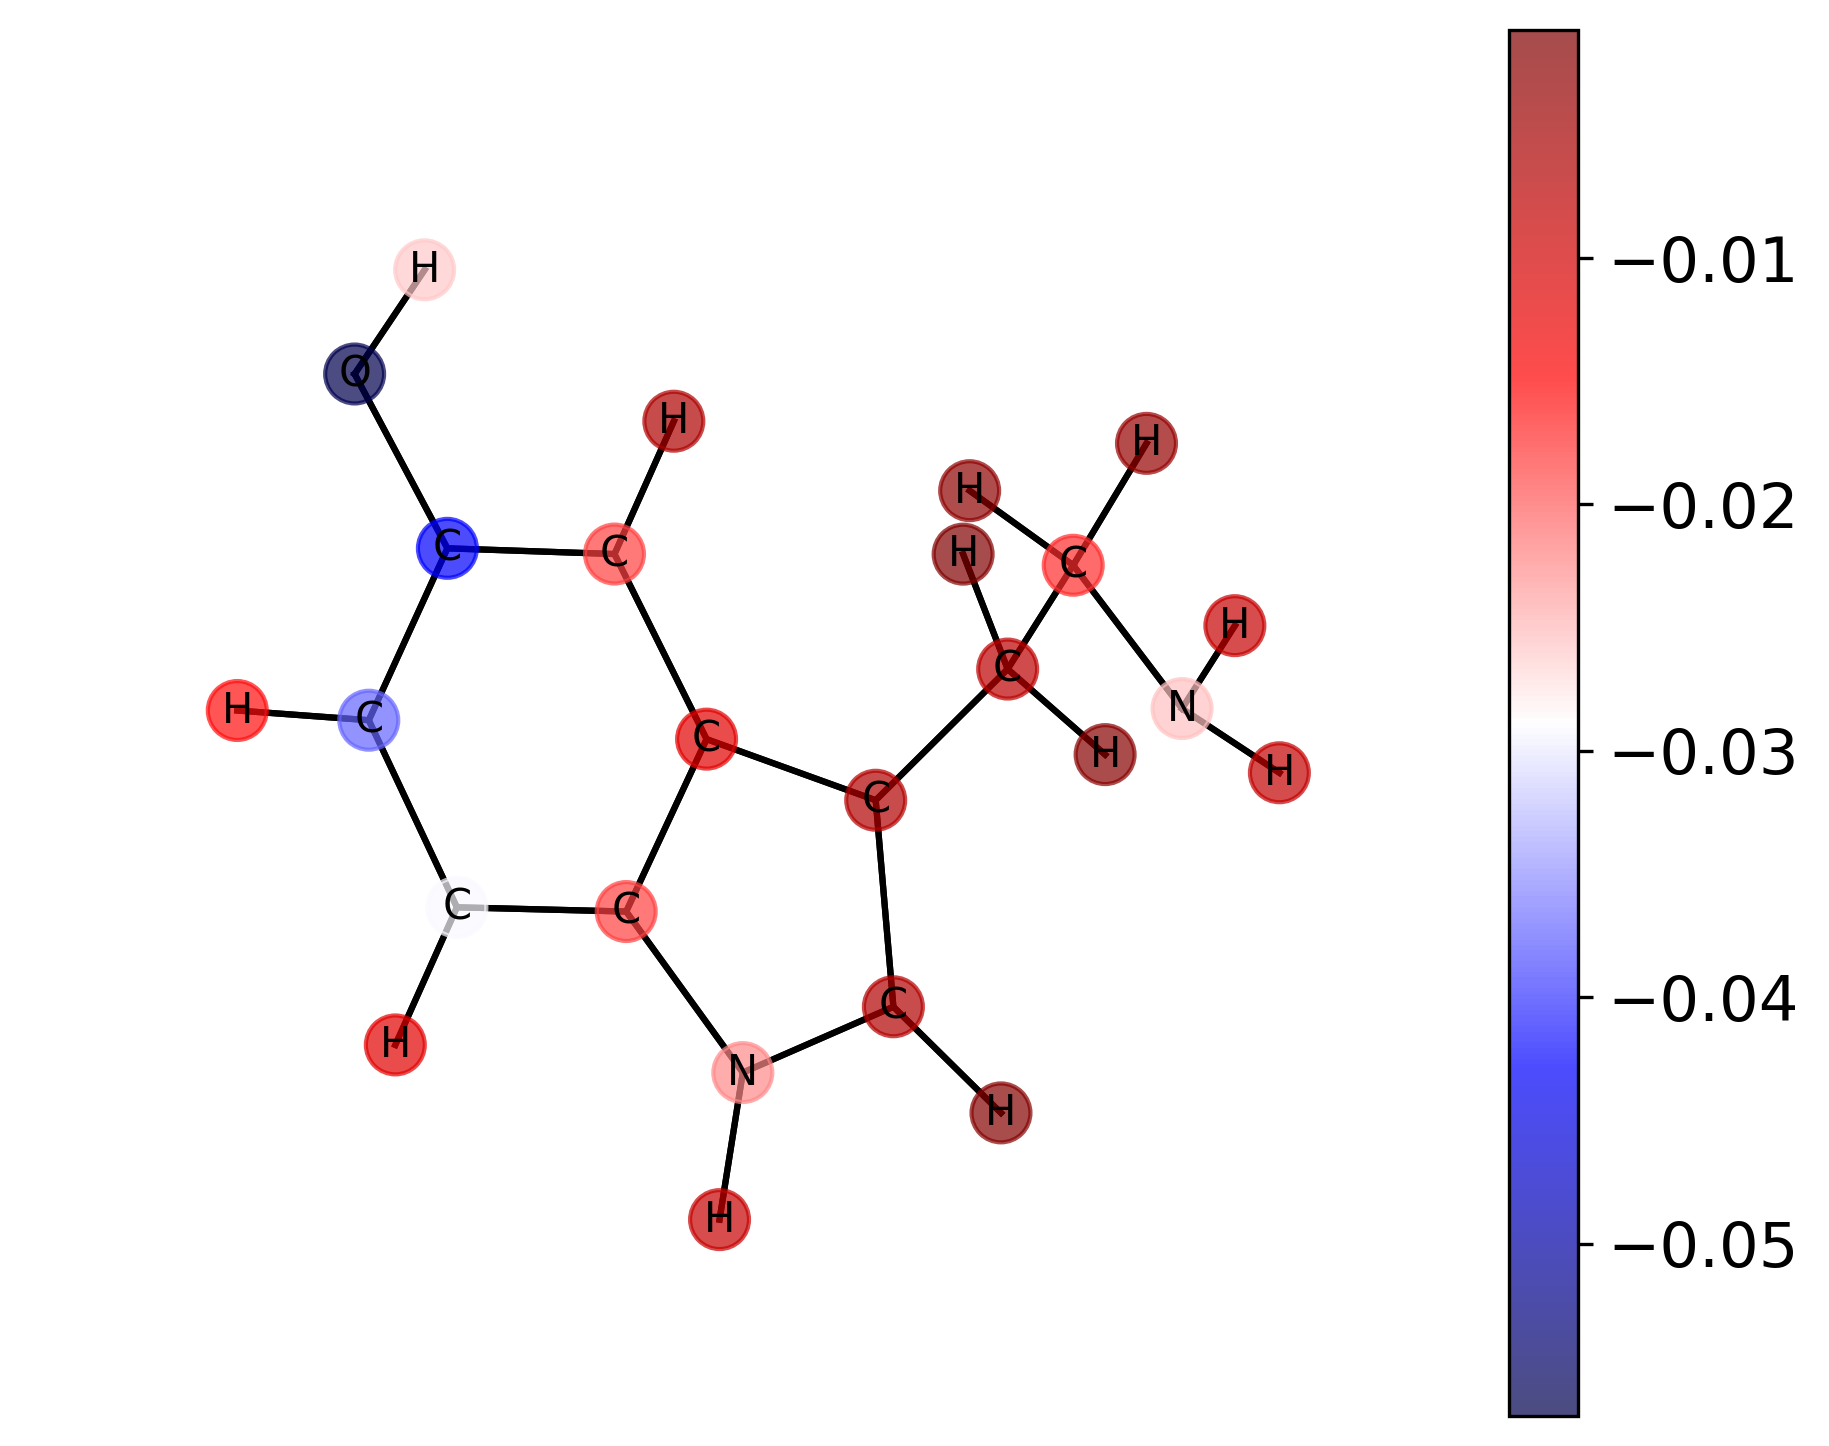

In [7]:
%matplotlib inline

fig, ax = plt.subplots(1, 1, figsize = (8, 6), dpi = 300,
                       subplot_kw = dict(projection = '3d'))

p = explainer.plot(ax)

ax.dist = 100

ax.view_init(azim = -100, elev = 90, roll = 0)
ax.set_box_aspect(None, zoom = 1.30)

cb = fig.colorbar(p)
# cb.set_label("Contribution", fontsize = 20)
cb.ax.tick_params(labelsize = 15)

plt.savefig(f"./explain_results/{parameters['target']}_{SMILES}.png", dpi = 300)
plt.show()

# XYZ File

In [8]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem

molecule = Chem.AddHs(Chem.MolFromSmiles(SMILES))
AllChem.EmbedMolecule(molecule, randomSeed = 42)
conf = molecule.GetConformer()
position = np.array(conf.GetPositions())

def xyzWriter():
    newFile = []
    newFile.append(str(data.mol_x.shape[0]))
    newFile.append(parameters['target'])
    for idx, atom in enumerate(molecule.GetAtoms()):
        newFile.append(f"{atom.GetSymbol()}\t{position[idx,0]}\t{position[idx,1]}\t{position[idx,2]}\t{score[idx].item()}")

    return '\n'.join(newFile)

print(xyzWriter())


25
FLVU
C	-3.17845489849289	0.6733460110266652	0.05240180311540855	-0.037307798862457275
C	-2.8213447921398114	-0.6427948650814923	0.25662936732042513	-0.029091477394104004
C	-1.5353845875484329	-1.081427021598576	0.031701763646652385	-0.018448591232299805
C	-0.5922695898928454	-0.19542085612071675	-0.4031286501390734	-0.011519253253936768
C	-0.9252031322945861	1.1283863696815373	-0.6151102320538752	-0.018356502056121826
C	-2.2169951945436583	1.5664617789037882	-0.38827187926370865	-0.0430225133895874
O	-2.531636499244187	2.8887169629447866	-0.6042445976602764	-0.05699652433395386
C	0.62922610780989	-0.8203650363658751	-0.5697691865387849	-0.00649416446685791
C	0.38682726947459084	-2.1327801104639716	-0.21503032461385888	-0.006632089614868164
N	-0.9099872073043668	-2.2675704584523837	0.1403152332705093	-0.022478938102722168
C	1.9085361555396543	-0.22102415447715815	-1.02463104808511	-0.0073661208152771
C	2.5786426891197967	0.5917883453630863	0.03544731766753256	-0.017398715019226074
N	

# Colormap

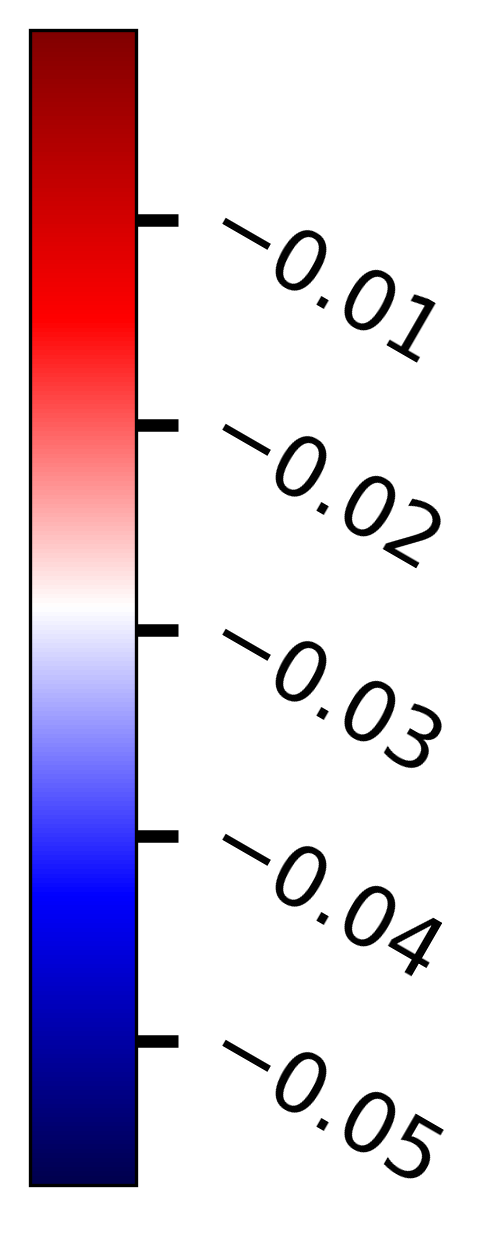

In [9]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(1, 2, figsize = (1, 5), dpi = 300)

ax[0].set_visible(False)
ax[1].tick_params(direction = 'out', width = 3, length = 10, labelsize = 20, rotation = -30)

p = ax[0].scatter(score, score, c = score, cmap = 'seismic')
fig.colorbar(p, cax = ax[1])

plt.show()